#### Part G)


#### Data generation and prosessing of data

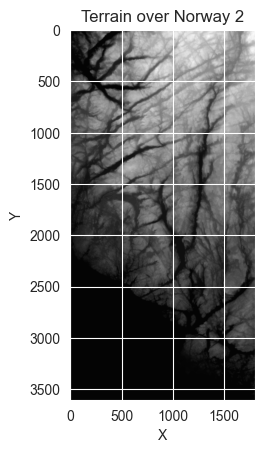

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imageio.v2 import imread
import os

def create_design_matrix(x, y, degree):
    num_terms = int((degree + 1)*(degree + 2)/2)
    X = np.zeros((len(x), num_terms))
    idx = 0
    for i in range(degree + 1):
        for j in range(degree + 1 - i):
            X[:, idx] = (x**i) * (y**j)
            idx += 1
    return X

# Defining MSE and R2 functions
def MSE(z_data, z_ols_model):
    return np.mean((z_data - z_ols_model)**2)

# The R2 function was taken from Week 35: From Ordinary Linear Regression to Ridge and Lasso Regression,
# Morten Hjorth-Jensen, Department of Physics, University of Oslo.
# https://github.com/CompPhysics/MachineLearning/blob/master/doc/LectureNotes/week37.ipynb
def R2(z_data, z_ols_model):
    return 1 - np.sum((z_data - z_ols_model)**2) / np.sum((z_data - np.mean(z_data))**2)

current_dir = os.path.dirname("codeG")
file_path = os.path.join(current_dir, '..', '..', 'Datafiles', 'SRTM_data_Norway_2.tif')
terrain1 = imread(file_path)

plt.figure()
plt.title('Terrain over Norway 2')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

seed = 315
np.random.seed(seed)

# Create linearly spaced values
n_rows, n_cols = terrain1.shape
x = np.linspace(0, 1, n_cols)
y = np.linspace(0, 1, n_rows)

X, Y = np.meshgrid(x, y)
x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = terrain1.flatten()

#as x and y is between 0 and 1 and z values were vastly different we need to normalize the values
z_min = z_flat.min()
z_max = z_flat.max()
z_normalized = (z_flat - z_min) / (z_max - z_min)

#as it took a long time to run the whole dataset, we use a subsection.
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(
    x_flat, y_flat, z_normalized, test_size=0.002,train_size=0.008, random_state=seed
)

# Centering the data by subtracting the mean, the values are already scaled between 0 and 1. 
x_mean = np.mean(x_train, axis=0)
y_mean = np.mean(y_train, axis=0)
z_mean = np.mean(z_train, axis=0)

x_train = x_train - x_mean
y_train = y_train - y_mean
z_train = z_train - z_mean

x_test = x_test - x_mean
y_test = y_test - y_mean
z_test = z_test - z_mean

### Part a) Ordinary Least Square (OLS) on  on real world data

MSE Train: 0.010134457724505556
MSE Test: 0.01003320867793183
R2 Train: 0.8255548657040509
R2 Test: 0.8274331479550543
MSE Train: [0.01656793795109411, 0.013944784950906109, 0.01166139549256852, 0.010844952288204372, 0.010491467552065968, 0.010134457724505556]
MSE Test: [0.016835355532378055, 0.01402565589143111, 0.01167098057445307, 0.010800936327024415, 0.010443579041634414, 0.01003320867793183]
R2 Train: [0.7148149176352134, 0.7599674349021345, 0.7992715784032204, 0.8133250727590092, 0.8194096304081202, 0.8255548657040509]
R2 Test: [0.7104391625313227, 0.7587647817618373, 0.7992641793207241, 0.8142285642685637, 0.8203749550967261, 0.8274331479550543]


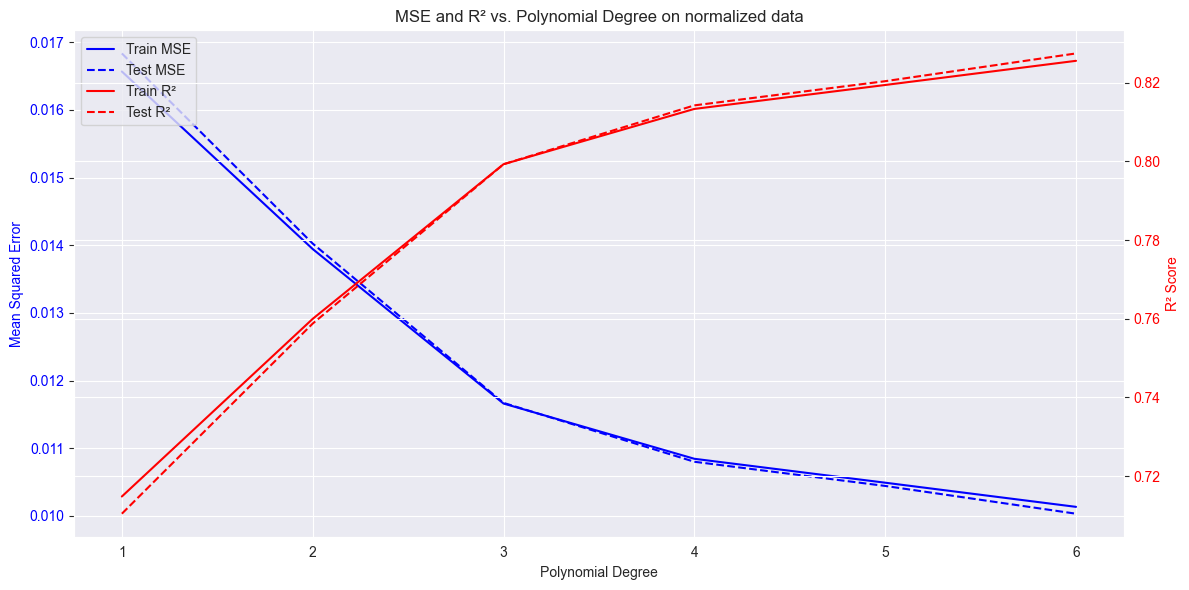

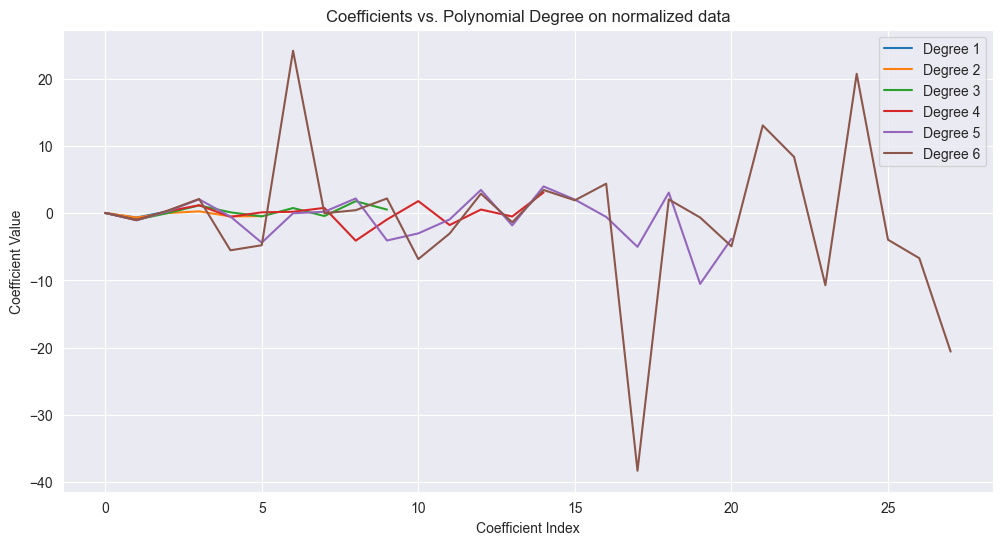

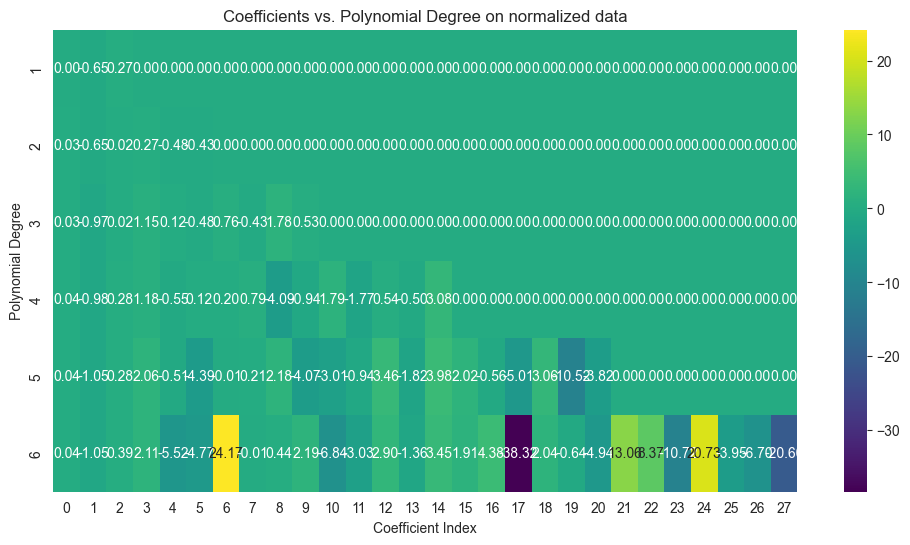

In [3]:
#About the same as part a) on Franke function
# Perform OLS and plot MSE and R2 as a function of polynomial degree and the coefficients.
from numpy.linalg import inv
import seaborn as sns

mse_train, mse_test, r2_train, r2_test, coefficients = [], [], [], [], []
degrees = list(range(1, 7))

for poly_degree in degrees:
    XY_train = create_design_matrix(x_train, y_train, poly_degree)
    XY_test = create_design_matrix(x_test, y_test, poly_degree)

    beta = inv(XY_train.T @ XY_train) @ XY_train.T @ z_train

    z_train_pred = XY_train @ beta
    z_test_pred = XY_test @ beta

    mse_train.append(MSE(z_train, z_train_pred))
    mse_test.append(MSE(z_test, z_test_pred))
    r2_train.append(R2(z_train, z_train_pred))
    r2_test.append(R2(z_test, z_test_pred))
    coefficients.append(beta)

#Print the best results
print(f'MSE Train: {min(mse_train)}')
print(f'MSE Test: {min(mse_test)}')
print(f'R2 Train: {max(r2_train)}')
print(f'R2 Test: {max(r2_test)}')

# Print results
print(f'MSE Train: {mse_train}')
print(f'MSE Test: {mse_test}')
print(f'R2 Train: {r2_train}')
print(f'R2 Test: {r2_test}')

# Plotting MSE and R² in one plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting MSE
ax1.plot(degrees, mse_train, 'b-', label='Train MSE')
ax1.plot(degrees, mse_test, 'b--', label='Test MSE')
ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('Mean Squared Error', color='b')
ax1.tick_params(axis='y', labelcolor='b')
# Creating a second y-axis for R²
ax2 = ax1.twinx()
ax2.plot(degrees, r2_train, 'r-', label='Train R²')
ax2.plot(degrees, r2_test, 'r--', label='Test R²')
ax2.set_ylabel('R² Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('MSE and R² vs. Polynomial Degree on normalized data')
fig.tight_layout()
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
plt.savefig("figures\g\MSE_R2_OLSTerrain.png")
plt.show()


# Plotting Coefficients
plt.figure(figsize=(12, 6))
for i, coef in enumerate(coefficients):
    plt.plot(np.arange(len(coef)), coef.flatten(), '-', label=f'Degree {degrees[i]}')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('Coefficients vs. Polynomial Degree on normalized data')
plt.legend()
plt.savefig("figures\g\coefficientsOLSTerrain.png")
plt.show()


# Convert coefficients to a 2D matrix with padding as required
def pad_coefficients(coefficients):
    max_length = max(len(coef) for coef in coefficients)
    padded_coefficients = np.array([np.pad(coef, (0, max_length - len(coef)), 'constant') for coef in coefficients])
    return padded_coefficients

coefficients_matrix = pad_coefficients(coefficients)

# Plotting Coefficients as Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(coefficients_matrix, annot=True, fmt=".2f", cmap="viridis", xticklabels=np.arange(coefficients_matrix.shape[1]), yticklabels=degrees)
plt.xlabel('Coefficient Index')
plt.ylabel('Polynomial Degree')
plt.title('Coefficients vs. Polynomial Degree on normalized data')
plt.savefig("figures\g\CoefficientsHeatmapOLSTerrain.png")
plt.show()


### Part b): Adding Ridge regression for real world data

minimum MSE Train: 0.00979163803943355
minimum MSE Test: 0.009693913070336372
maximum R2 Train: 0.8314558450783172
maximum R2 Test: 0.8332688857329607


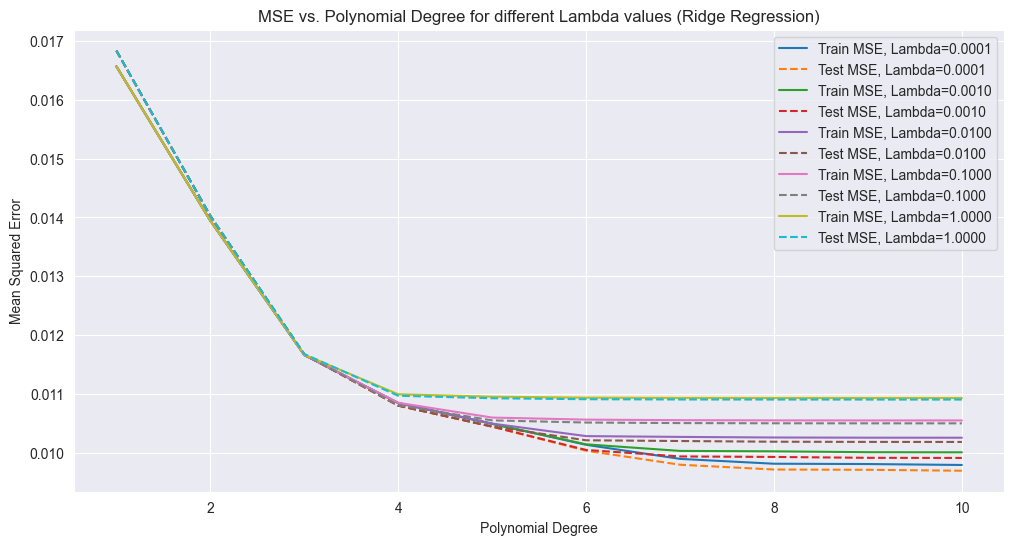

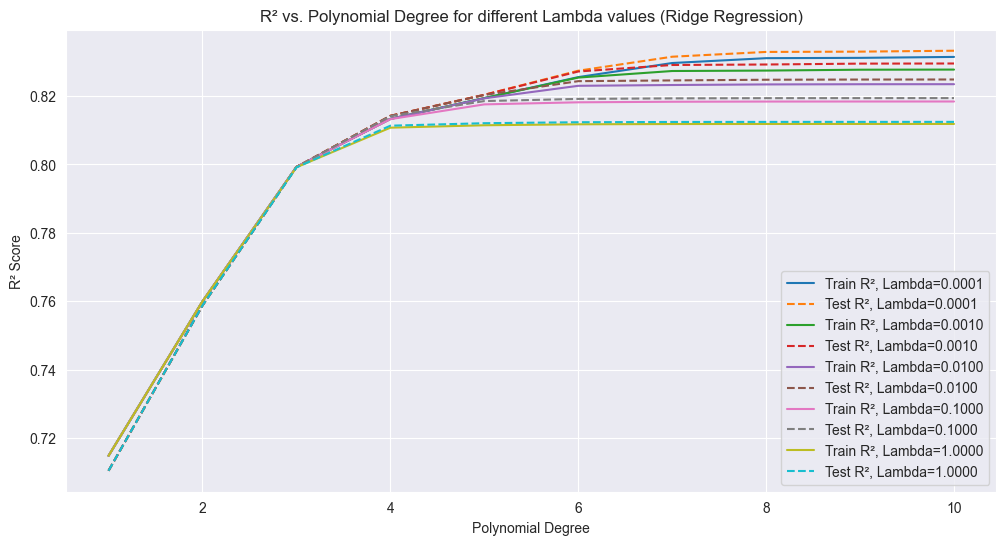

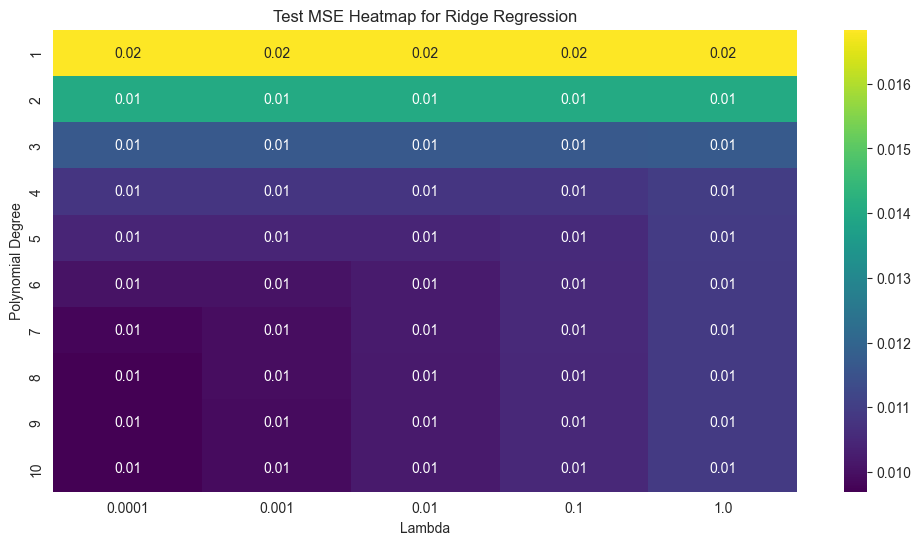

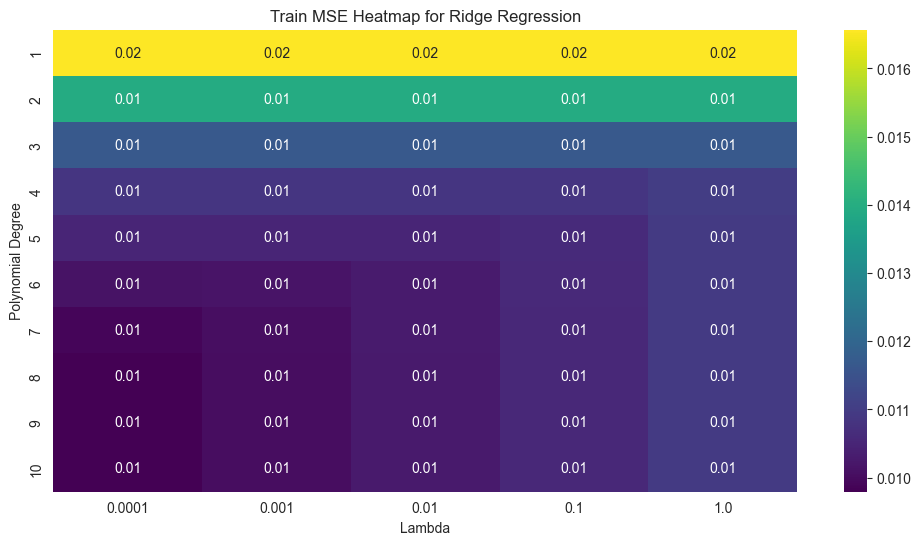

In [4]:
#About the same as part b) on Franke function
# Ridge Parameters
Maxpolydegree = 10
nlambdas = 5
lambdas = np.logspace(-4, 0, nlambdas)

# Initialize result storage
Error_train_ridge = np.zeros((Maxpolydegree, nlambdas))
Score_train_ridge = np.zeros((Maxpolydegree, nlambdas))
Error_test_ridge = np.zeros((Maxpolydegree, nlambdas))
Score_test_ridge = np.zeros((Maxpolydegree, nlambdas))
num_coefficients = int((Maxpolydegree + 1)*(Maxpolydegree + 2)/2)
betas_ridge = np.zeros((Maxpolydegree, nlambdas, num_coefficients))

#testmatrix2 = create_design_matrix(x_train, y_train, 3)
#print("design matrix without scaling",testmatrix2)

for degree in range(1, Maxpolydegree + 1):
    X_design_train = create_design_matrix(x_train, y_train, degree)
    X_design_test = create_design_matrix(x_test, y_test, degree)

    for i, lmbda in enumerate(lambdas):
        beta_ridge = inv(X_design_train.T @ X_design_train + lmbda * np.eye(X_design_train.shape[1])) @ X_design_train.T @ z_train
        z_est_train_ridge = X_design_train @ beta_ridge
        z_est_test_ridge = X_design_test @ beta_ridge

        Error_train_ridge[degree-1, i] = MSE(z_train, z_est_train_ridge)
        Score_train_ridge[degree-1, i] = R2(z_train, z_est_train_ridge)
        Error_test_ridge[degree-1, i] = MSE(z_test, z_est_test_ridge)
        Score_test_ridge[degree-1, i] = R2(z_test, z_est_test_ridge)

        betas_ridge[degree-1, i, :beta_ridge.shape[0]] = beta_ridge


# Print results best results
print(f'minimum MSE Train: {np.min(Error_train_ridge)}')
print(f'minimum MSE Test: {np.min(Error_test_ridge)}')
print(f'maximum R2 Train: {np.max(Score_train_ridge)}')
print(f'maximum R2 Test: {np.max(Score_test_ridge)}')

# Plotting MSE for Ridge Regression
plt.figure(figsize=(12, 6))
for i, lmbda in enumerate(lambdas):
    plt.plot(range(1, Maxpolydegree + 1), Error_train_ridge[:, i], '-', label=f'Train MSE, Lambda={lmbda:.4f}')
    plt.plot(range(1, Maxpolydegree + 1), Error_test_ridge[:, i], '--', label=f'Test MSE, Lambda={lmbda:.4f}')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Polynomial Degree for different Lambda values (Ridge Regression)')
plt.legend()
plt.savefig("figures\g\MSERidgeTerrain.png")
plt.show()

# Plotting R² for Ridge Regression
plt.figure(figsize=(12, 6))
for i, lmbda in enumerate(lambdas):
    plt.plot(range(1, Maxpolydegree + 1), Score_train_ridge[:, i], '-', label=f'Train R², Lambda={lmbda:.4f}')
    plt.plot(range(1, Maxpolydegree + 1), Score_test_ridge[:, i], '--', label=f'Test R², Lambda={lmbda:.4f}')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('R² vs. Polynomial Degree for different Lambda values (Ridge Regression)')
plt.legend()
plt.savefig("figures\g\R2RidgeTerrain.png")
plt.show()

# Plotting R² for Ridge Regression as Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(Error_test_ridge, annot=True, fmt=".2f", xticklabels=np.round(lambdas, 4), yticklabels=range(1, Maxpolydegree + 1), cmap="viridis")
plt.xlabel('Lambda')
plt.ylabel('Polynomial Degree')
plt.title('Test MSE Heatmap for Ridge Regression')
plt.savefig("figures\g\TrainR2HeatmapRidgeTerrain.png")
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(Error_train_ridge, annot=True, fmt=".2f", xticklabels=np.round(lambdas, 4), yticklabels=range(1, Maxpolydegree + 1), cmap="viridis")
plt.xlabel('Lambda')
plt.ylabel('Polynomial Degree')
plt.title('Train MSE Heatmap for Ridge Regression')
plt.savefig("figures\g\TestR2HeatmapRidgeTerrain.png")
plt.show()

### Part c): Adding Lasso for the real world data

minimum MSE Train: 0.011526470283360986
minimum MSE Test: 0.011531075729899812
maximum R2 Train: 0.8015940555282869
maximum R2 Test: 0.8016704821681369


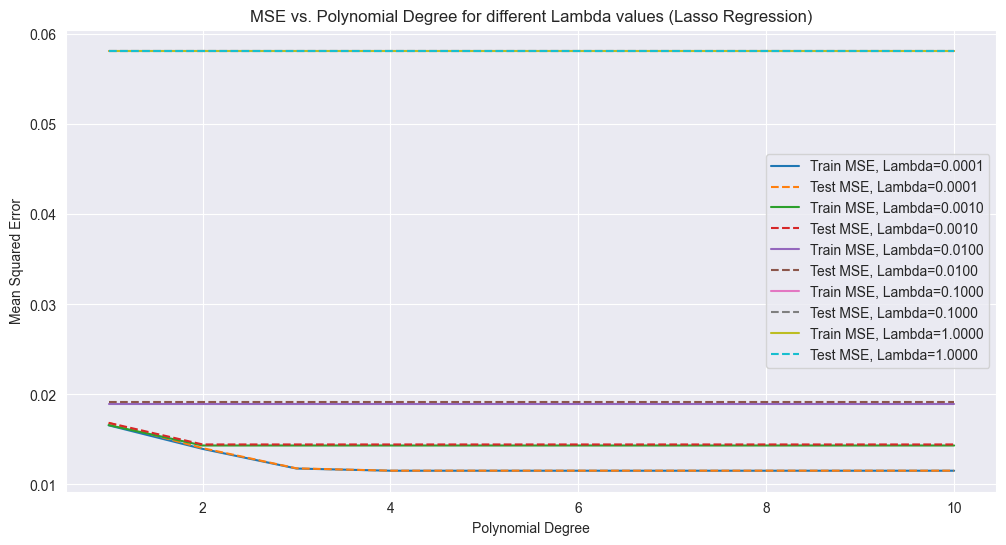

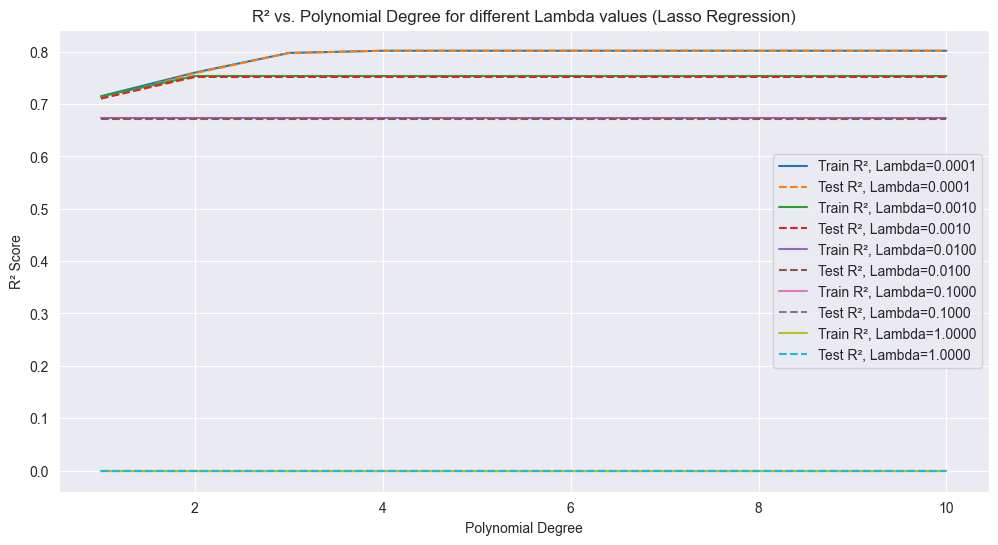

In [5]:
#About the same as part c) on Franke function
from sklearn.linear_model import Lasso

Maxpolydegree = 10
nlambdas = 5
lambdas = np.logspace(-4, 0, nlambdas)

Error_train_lasso = np.zeros((Maxpolydegree, nlambdas))
Score_train_lasso = np.zeros((Maxpolydegree, nlambdas))
Error_test_lasso = np.zeros((Maxpolydegree, nlambdas))
Score_test_lasso = np.zeros((Maxpolydegree, nlambdas))

num_coefficients = int((Maxpolydegree + 1)*(Maxpolydegree + 2)/2)
betas_lasso = np.zeros((Maxpolydegree, nlambdas, num_coefficients))

#testmatrix3 = create_design_matrix(x_train, y_train, 3)
#print("design matrix without scaling",testmatrix3)

for degree in range(1, Maxpolydegree + 1):
    X_design_train = create_design_matrix(x_train, y_train, degree)
    X_design_test = create_design_matrix(x_test, y_test, degree)

    for i, lmbda in enumerate(lambdas):
        lasso = Lasso(alpha=lmbda, fit_intercept=False, max_iter=10000)
        lasso.fit(X_design_train, z_train)
        beta_lasso = lasso.coef_

        z_est_train_lasso = lasso.predict(X_design_train)
        z_est_test_lasso = lasso.predict(X_design_test)

        Error_train_lasso[degree-1, i] = MSE(z_train, z_est_train_lasso)
        Score_train_lasso[degree-1, i] = R2(z_train, z_est_train_lasso)
        Error_test_lasso[degree-1, i] = MSE(z_test, z_est_test_lasso)
        Score_test_lasso[degree-1, i] = R2(z_test, z_est_test_lasso)

        betas_lasso[degree-1, i, :beta_lasso.shape[0]] = beta_lasso

# Print results best results
print(f'minimum MSE Train: {np.min(Error_train_lasso)}')
print(f'minimum MSE Test: {np.min(Error_test_lasso)}')
print(f'maximum R2 Train: {np.max(Score_train_lasso)}')
print(f'maximum R2 Test: {np.max(Score_test_lasso)}')

# Plotting MSE for LASSO
plt.figure(figsize=(12, 6))
for i, lmbda in enumerate(lambdas):
    plt.plot(range(1, Maxpolydegree + 1), Error_train_lasso[:, i], '-', label=f'Train MSE, Lambda={lmbda:.4f}')
    plt.plot(range(1, Maxpolydegree + 1), Error_test_lasso[:, i], '--', label=f'Test MSE, Lambda={lmbda:.4f}')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Polynomial Degree for different Lambda values (Lasso Regression)')
plt.legend()
plt.savefig("figures\g\MSELassoTerrain.png")
plt.show()

# Plotting R² for LASSO
plt.figure(figsize=(12, 6))
for i, lmbda in enumerate(lambdas):
    plt.plot(range(1, Maxpolydegree + 1), Score_train_lasso[:, i], '-', label=f'Train R², Lambda={lmbda:.4f}')
    plt.plot(range(1, Maxpolydegree + 1), Score_test_lasso[:, i], '--', label=f'Test R², Lambda={lmbda:.4f}')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('R² vs. Polynomial Degree for different Lambda values (Lasso Regression)')
plt.legend()
plt.savefig("figures\g\R2LassoTerrain.png")
plt.show()


### Part e): Bias-variance trade-off and resampling techniques

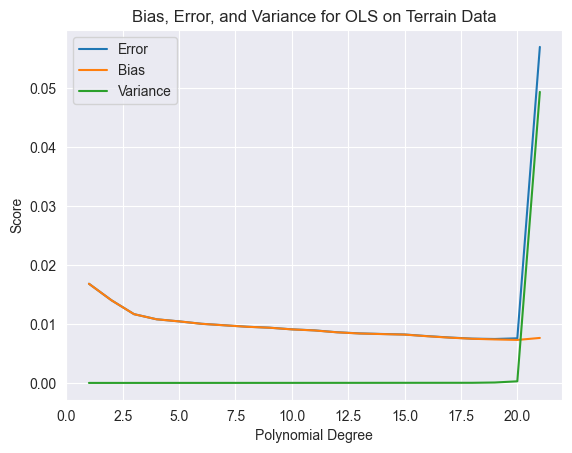

In [8]:
#About the same as part e) on Franke function
from sklearn.utils import resample

Maxpolydegree = 21
n_boostraps = 100

error = np.zeros(Maxpolydegree)
bias = np.zeros(Maxpolydegree)
variance = np.zeros(Maxpolydegree)
polydegree = np.zeros(Maxpolydegree)
#testmatrix4 = create_design_matrix(x_train, y_train, 3)
#print("design matrix without scaling",testmatrix4)

for degree in range(1, Maxpolydegree + 1):
    z_pred = np.empty((z_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        x_, y_, z_ = resample(x_train, y_train, z_train)
        design_m = create_design_matrix(x_, y_, degree)
        beta_m = inv(design_m.T @ design_m) @ design_m.T @ z_
        z_pred[:, i] = create_design_matrix(x_test, y_test, degree) @ beta_m

    polydegree[degree-1] = degree
    error[degree-1] = np.mean((z_test[:, np.newaxis] - z_pred)**2)
    bias[degree-1] = np.mean((z_test[:, np.newaxis] - np.mean(z_pred, axis=1, keepdims=True))**2)
    variance[degree-1] = np.mean(np.var(z_pred, axis=1, keepdims=True))

plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='Bias')
plt.plot(polydegree, variance, label='Variance')
plt.title("Bias, Error, and Variance for OLS on Terrain Data")
plt.xlabel('Polynomial Degree')
plt.ylabel('Score')
plt.legend()
plt.savefig("figures\g\BiasVarOLSTerrain.png")
plt.show()

### Part f):  Cross-validation as resampling techniques, adding more complexity

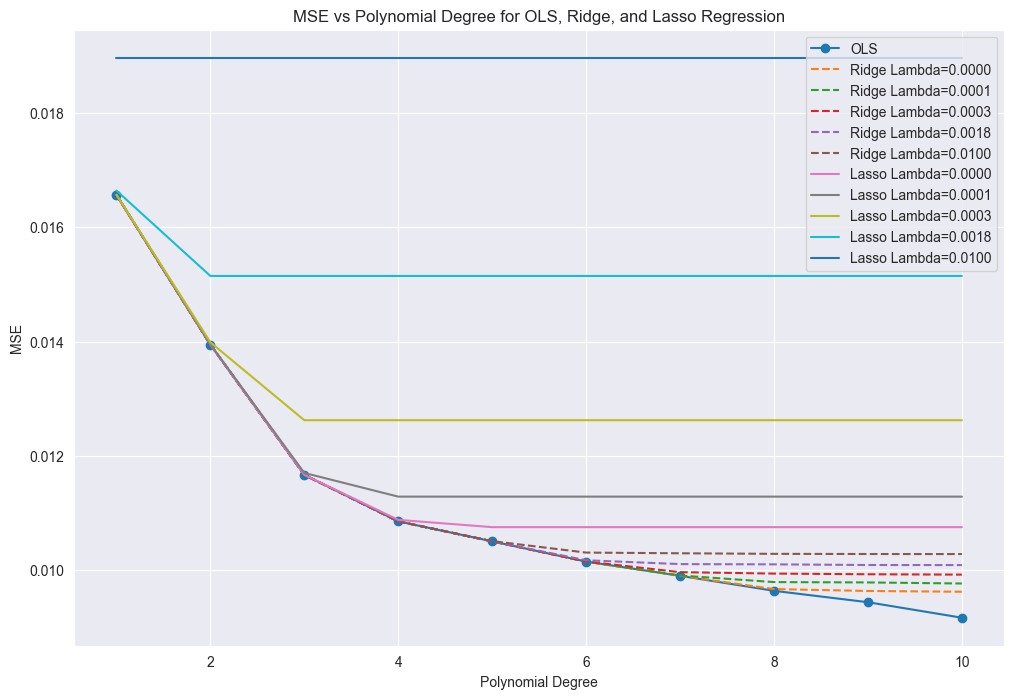

In [9]:
#About the same as part f) on Franke function
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso

# Set up k-fold cross-validation
Maxpolydegree = 10
k = 10
kfold = KFold(n_splits=k, shuffle=True, random_state=315)

# OLS Regression
ols_mse = np.zeros(Maxpolydegree)

for degree in range(1, Maxpolydegree + 1):
    X_design_temp = create_design_matrix(x_train, y_train, degree)
    model = LinearRegression()
    z_pred = cross_val_predict(model, X_design_temp, z_train, cv=kfold)
    scores = cross_val_score(model, X_design_temp, z_train, scoring='neg_mean_squared_error', cv=kfold)
    ols_mse[degree-1] = -np.mean(scores)

# Ridge Regression
nlambdas = 5
lambdas = np.logspace(-5,-2 , nlambdas)
ridge_mse = np.zeros((Maxpolydegree, nlambdas))

for degree in range(1, Maxpolydegree + 1):
    X_design_temp = create_design_matrix(x_train, y_train, degree)
    for i in range(nlambdas):
        lmbda = lambdas[i]
        ridge = Ridge(alpha=lmbda, fit_intercept=False)
        estimated_mse_folds = cross_val_score(ridge, X_design_temp, z_train, scoring='neg_mean_squared_error', cv=kfold)
        ridge_mse[degree-1, i] = np.mean(-estimated_mse_folds)

# Lasso Regression
lasso_mse = np.zeros((Maxpolydegree, nlambdas))

for degree in range(1, Maxpolydegree + 1):
    X_design_temp = create_design_matrix(x_train, y_train, degree)
    for i in range(nlambdas):
        lmbda = lambdas[i]
        lasso = Lasso(alpha=lmbda, fit_intercept=False, max_iter=10000)
        estimated_mse_folds = cross_val_score(lasso, X_design_temp, z_train, scoring='neg_mean_squared_error', cv=kfold)
        lasso_mse[degree-1, i] = np.mean(-estimated_mse_folds)

# Plotting all three MSEs in one plot
plt.figure(figsize=(12, 8))

# OLS MSE plot
plt.plot(range(1, Maxpolydegree + 1), ols_mse, marker='o', linestyle='-', label='OLS')

# Ridge MSE plot
for i, lmbda in enumerate(lambdas):
    plt.plot(range(1, Maxpolydegree + 1), ridge_mse[:, i], linestyle='--', label=f'Ridge Lambda={lmbda:.4f}')

# Lasso MSE plot
for i, lmbda in enumerate(lambdas):
    plt.plot(range(1, Maxpolydegree + 1), lasso_mse[:, i], linestyle='-', label=f'Lasso Lambda={lmbda:.4f}')

plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE vs Polynomial Degree for OLS, Ridge, and Lasso Regression')
plt.legend()
plt.savefig("figures\g\CVoneplotTerrain2.png")
plt.show()
